In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import LongformerModel, LongformerTokenizer
from transformers import RobertaTokenizer, RobertaModel, DistilBertTokenizer, DistilBertModel
from torch import cuda
import pandas as pd
import numpy as np
import glob
import os
import jsonlist
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.cuda.amp import autocast

/home/ignacio/.local/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/ignacio/.local/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
class FeverDataset(Dataset):
    def __init__(self, type):
        self.type = type
        
        # from json file to dictionary
        with open(f'{self.type}.jsonl', 'r') as f:
            self.dataset = jsonlist.load(f)
        

    def __len__(self):            
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]
    
fever = FeverDataset('train')
print('Number of samples:', len(fever))

Number of samples: 145449


In [3]:
import unicodedata

class WikiDataset(Dataset):
    def __init__(self, type='train', reduced=True):
        # open all json files in directory 'wiki-pages' and create a dictionary
        self.dataset = []
        for file in glob.glob('wiki-pages/*.jsonl'):
            with open(file, 'r') as f:
                self.dataset.append(jsonlist.load(f))
        self.dataset = [item for sublist in self.dataset for item in sublist]
        if reduced:
            wiki_dict = {}
            fever = FeverDataset(type)
            for statement in fever:
                for evidences in statement['evidence']:
                    for evidence in evidences:
                        if evidence[2] is not None:
                            wiki_dict[unicodedata.normalize('NFC', evidence[2])] = wiki_dict.get(unicodedata.normalize('NFC', evidence[2]), []) + [statement['id']]
            # keep in self.dataset only the pages that are in wiki_dict.keys()
            self.dataset = [page for page in self.dataset if page['id'] in wiki_dict]


    def __len__(self):            
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]

wiki = WikiDataset('train', reduced=False)
print('Number of samples:', len(wiki))

Number of samples: 5416537


Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors


Percentage of pages with more than 512 tokens:  1.8152188381617258


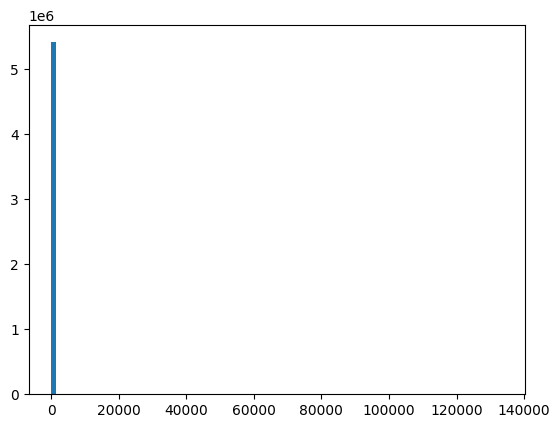

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")

l = []
for p in wiki:
    l.append(len(tokenizer(p['text']).input_ids))
plt.hist(l, bins=100)
# percentage of pages with more than 512 tokens
print('Percentage of pages with more than 512 tokens: ', 100*sum([1 for i in l if i > 512])/len(l))


In [18]:
# create a dictionary with the id of the wiki page as key and the id of the sentence as value
wiki_dict = {}
for statement in fever:
    #print('*'*75)
    for evidences in statement['evidence']:
        #print('-'*50)
        for evidence in evidences:
            #print(evidence)
            wiki_dict[evidence[2]] = wiki_dict.get(evidence[2], []) + [statement['id']]

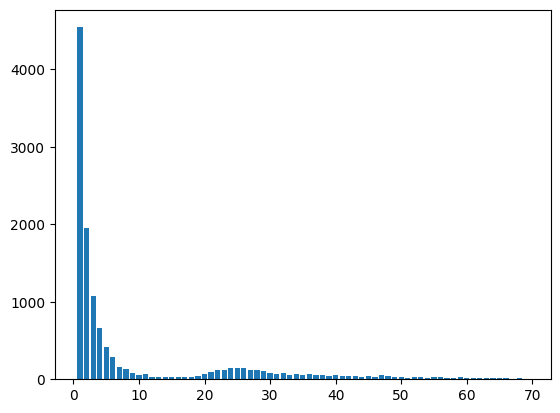

In [45]:
# plot distribution of the number of sentences per wiki page
sentence_count = [len(set(wiki_dict[i])) for i in wiki_dict.keys()]
plt.bar(range(1, 70), [sentence_count.count(i) for i in range(1, 70)])
plt.show()

In [49]:
for key in wiki_dict:
    if len(set(wiki_dict[key])) > 150:
        print(key, set(wiki_dict[key]))

None {4, 13, 131086, 18, 22, 131096, 131102, 34, 131108, 38, 131115, 44, 46, 131119, 131120, 131122, 131132, 60, 131137, 72, 131150, 131152, 82, 131154, 88, 90, 131164, 93, 94, 131165, 131178, 131183, 113, 114, 116, 131189, 118, 131191, 131192, 131194, 131200, 130, 132, 136, 131216, 131221, 151, 154, 131226, 160, 131238, 131240, 172, 131246, 174, 176, 178, 182, 184, 131256, 131260, 188, 131267, 131273, 131276, 131278, 208, 131284, 131285, 215, 216, 131289, 222, 131298, 227, 131303, 232, 131305, 234, 236, 131308, 131310, 238, 131316, 249, 131321, 131324, 253, 254, 255, 256, 258, 131332, 260, 268, 272, 274, 276, 131355, 284, 131358, 286, 287, 131359, 294, 131370, 298, 300, 131374, 308, 312, 131385, 131387, 318, 131391, 131392, 321, 322, 131395, 131400, 330, 131403, 131413, 131414, 131419, 131432, 131436, 131437, 131439, 131441, 131442, 372, 131453, 382, 389, 131462, 131461, 131468, 131470, 131473, 131474, 404, 131482, 131494, 131500, 428, 131507, 436, 131509, 437, 442, 131518, 131521, 13

In [51]:
count = 0
for page in wiki_dict.keys():
    if len(set(wiki_dict[page])) > 2:
        count += 1
print(f'{count}/{len(wiki_dict.keys())} = {count/len(wiki_dict.keys())*100}%')

6057/12550 = 48.26294820717131%


In [52]:
# percentage of fever for each label
labels = [statement['verifiable'] for statement in fever]
print('Verifiable', labels.count('VERIFIABLE')/len(labels)*100)
print('Not Verifiable:', labels.count('NOT VERIFIABLE')/len(labels)*100)


Verifiable 75.49725333278332
Not Verifiable: 24.502746667216687


In [53]:
# percentage of fever for each label
labels = [statement['label'] for statement in fever]
print('Supports:', labels.count('SUPPORTS')/len(labels)*100)
print('Refutes:', labels.count('REFUTES')/len(labels)*100)
print('Not enough info:', labels.count('NOT ENOUGH INFO')/len(labels)*100)


Supports: 55.026160372364195
Refutes: 20.471092960419117
Not enough info: 24.502746667216687


In [10]:
#get the difference between the keys of wiki_dict and wiki
wiki_dict_keys = set(wiki_dict.keys())
wiki_keys = set([page['id'] for page in wiki.dataset])
print('Numero de articulos referenciados no existentes: ', len(wiki_dict_keys - wiki_keys))
print(wiki_dict_keys - wiki_keys)

Numero de articulos referenciados no existentes:  142
{'Sophia_Abrahão', 'Ólafur_Arnalds', 'Grégory_Levasseur', '2015_Critérium_du_Dauphiné', 'Thénardiers', 'Cría_Cuervos', 'Beyoncé', 'École_Polytechnique_de_Montréal', "Musée_National_d'Art_Moderne", 'Princess_Märtha_Louise_of_Norway', 'Sofía_Vergara', 'Valérian_and_Laureline', 'Château_de_Lusignan', 'Isabella_Braña', 'Peer_Åström', 'Franco-Provençal_language', 'Reichsführer-SS', 'Régine_Chassagne', 'Parti_Québécois', 'Beyoncé_-LRB-album-RRB-', 'José_María_Chacón', 'Where_Are_Ü_Now', 'Battle_of_São_Mamede', 'Mission_San_Francisco_de_Asís', 'Trophées_UNFP_du_football', 'Henri_Poincaré', 'Tré_Cool', 'Jeroen_Krabbé', 'Kantō_region', "Musée_d'Orsay", 'Juan_Martín_del_Potro', 'Patrice_Chéreau', "1987_Fijian_coups_d'état", 'Stellan_Skarsgård', 'Penélope_Cruz', 'Caché_-LRB-film-RRB-', 'Éomer', 'José_Aldo', 'Alcázar_of_Seville', 'Baby_Boy_-LRB-Beyoncé_song-RRB-', "2014_Thai_coup_d'état", 'Cédula_

In [28]:
p = [page['id'] for page in wiki.dataset]

# find in p a the ids that contain the string 'Sophia'
for i in p:
    if 'Sophia_Abrahão' in i:
        print(i)



Sophia_Abrahão
Sophia_Abrahão_-LRB-album-RRB-
Sophia_Abrahão_discography
List_of_awards_and_nominations_received_by_Sophia_Abrahão
Sophia_-LRB-Sophia_Abrahão_EP-RRB-


In [41]:
'ã' == 'ã' 

False

In [42]:
import unicodedata

s1 = 'ã'
s2 = 'ã'

# Normalize to form 'NFC' (Canonical Composition)
s1_normalized = unicodedata.normalize('NFC', s1)
s2_normalized = unicodedata.normalize('NFC', s2)

print(s1_normalized == s2_normalized)  # This should print True

True
